In [80]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [81]:
# Image Preprocessing Function
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128))
    image = cv2.GaussianBlur(image, (3, 3), 0)
    image = cv2.equalizeHist(image)  # Apply Histogram Equalization enhances contrast
    return image 


In [82]:
# Load and preprocess dataset
def load_dataset(dataset_path="D:/projects/graduation/data_trial"):
    images, labels = [], []
    for label, category in enumerate(['normal', 'dyslexic']):  # normal 0, dyslexic 1
        category_path = os.path.join(dataset_path, category)
        for filename in os.listdir(category_path):
            image_path = os.path.join(category_path, filename)
            images.append(preprocess_image(image_path))
            labels.append(label)
    return np.array(images).reshape(-1, 128, 128, 1), np.array(labels)

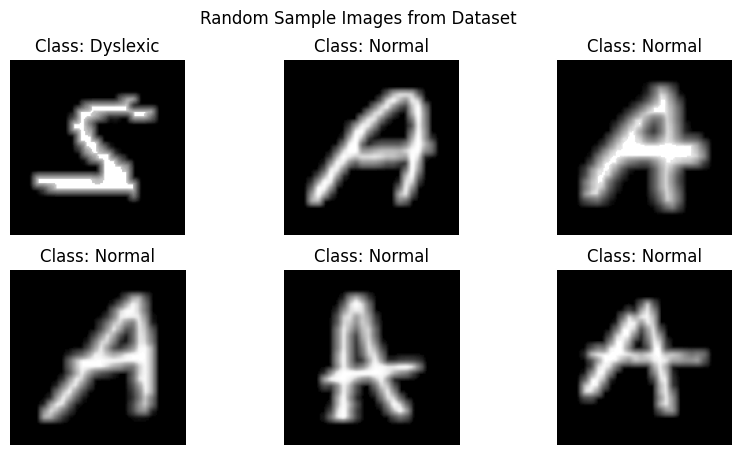

In [83]:
import random

# Shuffle the dataset
indices = list(range(len(images)))
random.shuffle(indices)
images = images[indices]
labels = labels[indices]

# Visualization
plt.figure(figsize=(10, 5))
for i in range(6):  # Display 6 random images
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Class: {'Normal' if labels[i] == 0 else 'Dyslexic'}")
    plt.axis('off')

plt.suptitle("Random Sample Images from Dataset")
plt.show()


In [84]:
def get_data_generators(dataset_path):
    datagen = ImageDataGenerator(
        rescale=1./255,  
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        zoom_range=0.1,  #
        validation_split=0.2  
    )
    
    train_gen = datagen.flow_from_directory(
        dataset_path, target_size=(128, 128), batch_size=32, color_mode='grayscale',
        class_mode='binary', subset='training'
    )
    
    val_gen = datagen.flow_from_directory(
        dataset_path, target_size=(128, 128), batch_size=32, color_mode='grayscale',
        class_mode='binary', subset='validation'
    )
    
    return train_gen, val_gen

In [85]:
train_gen, val_gen = get_data_generators(dataset_path="D:/projects/graduation/data_trial")
print(f"Training images: {train_gen.samples}")
print(f"Validation images: {val_gen.samples}")

Found 650 images belonging to 2 classes.
Found 162 images belonging to 2 classes.
Training images: 650
Validation images: 162


Found 650 images belonging to 2 classes.
Found 162 images belonging to 2 classes.
Number of images in batch: 32


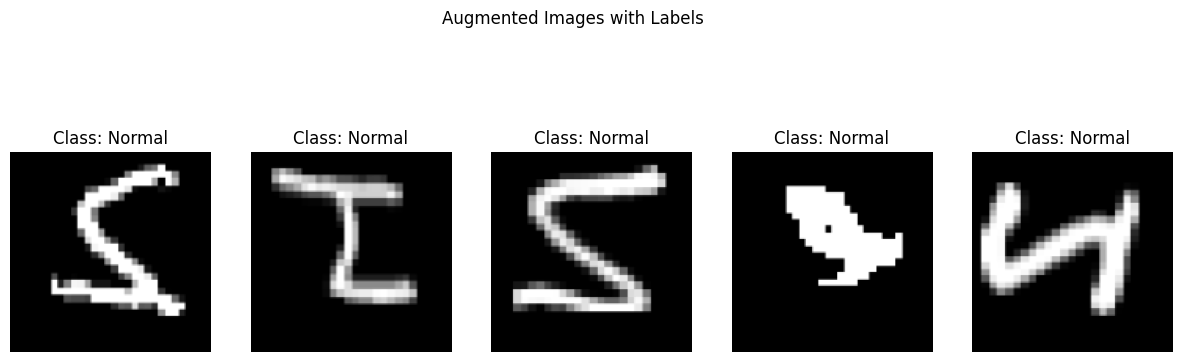

In [86]:
# Visualizing Augmented Images with Labels
def visualize_augmentations(generator):
    images, labels = next(generator)  # Get one batch of images and labels
    print(f"Number of images in batch: {len(images)}")  # Debugging
    
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    class_names = ['Normal', 'Dyslexic']  # Define class labels

    for i in range(min(5, len(images))):  # Show max 5 images
        axes[i].imshow(images[i].squeeze(), cmap='gray')
        label = int(labels[i])  # Convert label to integer
        axes[i].set_title(f"Class: {class_names[label]}")  # Display label
        axes[i].axis('off')

    plt.suptitle("Augmented Images with Labels")
    plt.show()


# Call the functions
dataset_path = "D:/projects/graduation/data_trial"  # Your dataset folder path
train_gen, val_gen = get_data_generators(dataset_path)
visualize_augmentations(train_gen)


Found 650 images belonging to 2 classes.
Found 162 images belonging to 2 classes.
Number of images in batch: 32


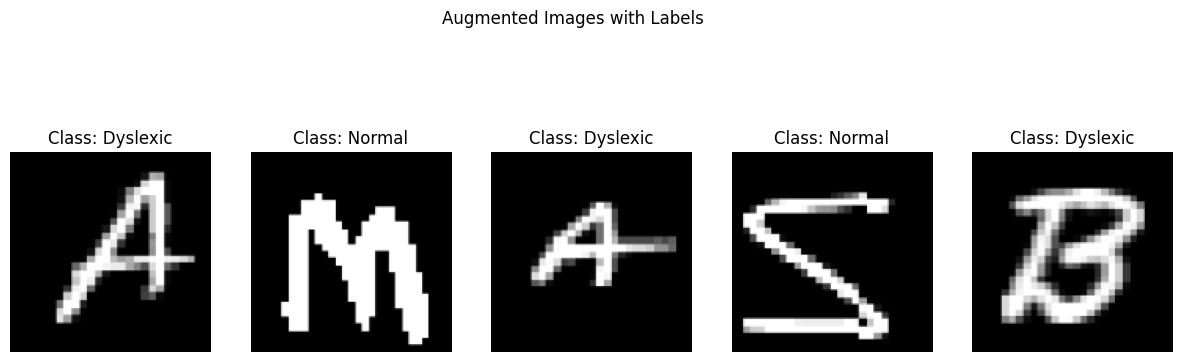

Epoch 1/30
21/21 [==============================] - 13s 607ms/step - loss: 0.5941 - accuracy: 0.6938 - val_loss: 0.5427 - val_accuracy: 0.7346
Epoch 2/30
21/21 [==============================] - 12s 569ms/step - loss: 0.4027 - accuracy: 0.8154 - val_loss: 0.3307 - val_accuracy: 0.8580
Epoch 3/30
21/21 [==============================] - 12s 577ms/step - loss: 0.3394 - accuracy: 0.8431 - val_loss: 0.3645 - val_accuracy: 0.8519
Epoch 4/30
21/21 [==============================] - 12s 576ms/step - loss: 0.2971 - accuracy: 0.8723 - val_loss: 0.2683 - val_accuracy: 0.9198
Epoch 5/30
21/21 [==============================] - 12s 573ms/step - loss: 0.3435 - accuracy: 0.8462 - val_loss: 0.2802 - val_accuracy: 0.9074
Epoch 6/30
21/21 [==============================] - 12s 572ms/step - loss: 0.2739 - accuracy: 0.8923 - val_loss: 0.2713 - val_accuracy: 0.9198
Epoch 7/30
21/21 [==============================] - 13s 616ms/step - loss: 0.2208 - accuracy: 0.9108 - val_loss: 0.2237 - val_accuracy: 0.9259

KeyboardInterrupt: 

In [88]:
# Main Execution
dataset_path = 'dataset_path'  
train_generator, validation_generator = get_data_generators(dataset_path="D:/projects/graduation/data_trial")
visualize_augmentations(train_generator)

# Define CNN model
def build_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 1)),
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Dropout(0.25),
        
        Conv2D(64, (3,3), activation='relu'),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Dropout(0.25),
        
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model()
model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

model.save('dyslexia_detection_cnn.h5')


In [ ]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

plt.show()


In [ ]:
# Generate predictions
y_true = np.array(validation_generator.labels)
y_pred = model.predict(validation_generator, steps=len(validation_generator))
y_pred = (y_pred > 0.5).astype(int).flatten()  # Convert probabilities to binary labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Dyslexic'], yticklabels=['Normal', 'Dyslexic'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=['Normal', 'Dyslexic']))
